In [7]:
#####################
# File system manangement
import os
import sys
import time
import librosa
import logging
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
from time import time
from pathlib import Path
from pprint import pprint
from pandas import read_csv
import matplotlib.pyplot as plt
from librosa.effects import trim

# sklearn Algoritm of Machine Learning # Classifier Libraries
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier

#
from sklearn.preprocessing import LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV,GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler,MinMaxScaler, OneHotEncoder, LabelEncoder

#Grid Search
from sklearn.pipeline import Pipeline
from sklearn.model_selection import ShuffleSplit,cross_val_score,train_test_split
from sklearn.model_selection import StratifiedKFold,StratifiedShuffleSplit, KFold ,RepeatedKFold, RepeatedStratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imbpipeline



# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')
import warnings # supress warnings

In [8]:
# load all data from file that we will use for your homework
dev_tsv = pd.read_csv('development.csv',sep=',')
ev_tsv  = pd.read_csv('evaluation.csv',sep=',')
print("Shape of the original dataset: ")
print('development.shape :' ,dev_tsv.shape)
print('evaluation.shape  :' ,ev_tsv.shape)

print("show original dataset: ")
print('Development:')
display(dev_tsv.tail(2))
print('Evaluation:')
display(ev_tsv.head(2))

Shape of the original dataset: 
development.shape : (9854, 10)
evaluation.shape  : (1455, 8)
show original dataset: 
Development:


,Id,path,speakerId,action,object,Self-reported fluency level,First Language spoken,Current language used for work/school,gender,ageRange
9852,9852,dsl_data/audio/speakers/vnljypgejkINbBAY/5ef42...,vnljypgejkINbBAY,deactivate,lights,native,English (United States),English (United States),male,22-40
9853,9853,dsl_data/audio/speakers/vnljypgejkINbBAY/61b7a...,vnljypgejkINbBAY,increase,volume,native,English (United States),English (United States),male,22-40


Evaluation:


,Id,path,speakerId,Self-reported fluency level,First Language spoken,Current language used for work/school,gender,ageRange
0,0,dsl_data/audio/speakers/NgQEvO2x7Vh3xy2xz/f53c...,NgQEvO2x7Vh3xy2xz,native,English (United States),English (United States),male,22-40
1,1,dsl_data/audio/speakers/k5bqyxx2lzIbrlg9/1d5f8...,k5bqyxx2lzIbrlg9,native,English (United States),English (United States),male,22-40


# Load the data from path

In [9]:
# Read audio
from scipy.io import wavfile

def load_data_from_audio(list_paths_audio):
    path = '/Users/surelmanda/Downloads/Surel_Esame_Gennaio_2023/'
    # Allocate space for data extration and sample rate
    # sample_rate holds the sample rate of the wav file
    # in (sample/sec) format
    # data is the numpy array that consists
    # of actual data read from the wav file
    X_audio , SR_audio  = [], []
    for file in list_paths_audio:
        sr, data = wavfile.read(os.path.join(path, file)) # this return sr: sample rate, data: audio as array.
        X_audio.append(data.astype(np.float32))
        SR_audio.append(sr)
    # convert to dataframe
    ds ={'Audio_features':X_audio,'Sample_Rate':SR_audio}
    return pd.DataFrame(ds)

In [10]:
#For each path from dataframe we will Extract Feature and sample rate using the function load_data_from_audio():
TrainExtration = load_data_from_audio(dev_tsv.path.tolist())
EvaluationExtration = load_data_from_audio(ev_tsv.path.tolist())

In [11]:
DataTrain = pd.concat([dev_tsv,TrainExtration],axis=1,sort=True)
#delete the column path:
DataTrain.drop('path', axis=1, inplace=True)
#add new column with name Target:
DataTrain['Target']=DataTrain.action+DataTrain.object
print("Train dataset: ")
display(DataTrain.head(3))

print("\n")

DataEval = pd.concat([ev_tsv,EvaluationExtration],axis=1,sort=True)
#delete the column path:
DataEval.drop('path', axis=1, inplace=True)
print("Eval dataset: ")
display(DataEval.head(3))

Train dataset: 


,Id,speakerId,action,object,Self-reported fluency level,First Language spoken,Current language used for work/school,gender,ageRange,Audio_features,Sample_Rate,Target
0,0,2BqVo8kVB2Skwgyb,change language,none,advanced,English (United States),English (United States),female,22-40,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",16000,change languagenone
1,1,2BqVo8kVB2Skwgyb,activate,music,advanced,English (United States),English (United States),female,22-40,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",16000,activatemusic
2,2,2BqVo8kVB2Skwgyb,deactivate,lights,advanced,English (United States),English (United States),female,22-40,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",16000,deactivatelights




Eval dataset: 


,Id,speakerId,Self-reported fluency level,First Language spoken,Current language used for work/school,gender,ageRange,Audio_features,Sample_Rate
0,0,NgQEvO2x7Vh3xy2xz,native,English (United States),English (United States),male,22-40,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",16000
1,1,k5bqyxx2lzIbrlg9,native,English (United States),English (United States),male,22-40,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",16000
2,2,7B4XmNppyrCK977p,native,English (United States),English (United States),male,41-65,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",16000


# Part 1:  Handle Audio Feature

In [12]:
# Before applying the preprocessing however, some considerations have to be done: - Were the audios
#recorded in the same conditions? - Do the audios have the same duration?
#To answer these questions we can perform some simple checks and adopt visualization techniques
#to look our data.
dev_SR = DataTrain.Sample_Rate.tolist()
eval_SR = DataEval.Sample_Rate.tolist()
SR = dev_SR[0]
print(f"Sampling rate = {SR} [sample/s]")
print("Do the sampling rate is always the same for all the development recordings? ",all([sr == SR for sr in dev_SR]))
print("Do the sampling rate for the evaluation set is equal to development set? ",all([sr == SR for sr in eval_SR]))

Sampling rate = 16000 [sample/s]
Do the sampling rate is always the same for all the development recordings?  False
Do the sampling rate for the evaluation set is equal to development set?  True


In [13]:
# We will visulize this information:
print("Explore Sample_Rate for DataTrain:")
unique, counts = np.unique(DataTrain.Sample_Rate, return_counts = True)
ds ={'Sample Rate':list(unique), 'count':list(counts)}
df_unique = pd.DataFrame(ds)
display(df_unique)
print("")
print("Explore Sample_Rate for DataEval:")
unique, counts = np.unique(DataEval.Sample_Rate, return_counts = True)
ds ={'Sample Rate':list(unique), 'count':list(counts)}
df_unique = pd.DataFrame(ds)
display(df_unique)

Explore Sample_Rate for DataTrain:


,Sample Rate,count
0,16000,9554
1,22050,300



Explore Sample_Rate for DataEval:


,Sample Rate,count
0,16000,1455


In [14]:
DataTrain.Target.value_counts()

increasevolume         2614
decreasevolume         2386
increaseheat           1209
decreaseheat           1189
change languagenone    1113
activatemusic           791
deactivatelights        552
Name: Target, dtype: int64

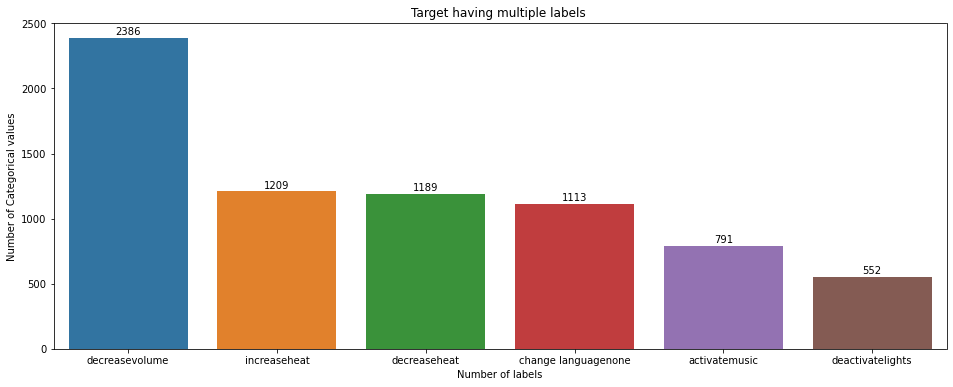

In [15]:
rowSums = DataTrain.Target
multiLabel_counts = rowSums.value_counts()
multiLabel_counts = multiLabel_counts.iloc[1:]
plt.figure(figsize=(16,6))
ax = sns.barplot(multiLabel_counts.index, multiLabel_counts.values)
plt.title("Target having multiple labels ")
plt.ylabel('Number of Categorical values')
plt.xlabel('Number of labels')
#adding the text labels
rects = ax.patches
labels = multiLabel_counts.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 10, label, 
            ha='center', va='bottom')

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
sns.barplot(x = list(DataTrain.Target), y= list(DataTrain.Target))
plt.title('Total comments in each category')
plt.xlabel('Number of comments')
plt.ylabel('Types of comments')

In [17]:
mask1=DataTrain['Sample_Rate']==16000
DataTrain_1 = DataTrain[mask1].copy()

mask2=DataTrain['Sample_Rate']==22050
DataTrain_2 = DataTrain[mask2].copy()

In [18]:
#Downsample for audio with sample rate uguale to 22050 in (sample/sec) format
#Downsampling refers to converting a higher sampling rate to a lower one. 
#For example, converting audio recorded at 96 kHz down to 44.1 kHz for CD production. 
#Downsampling often comes in to play with Internet audio and other formats where there are bandwidth limitations.

def Downsample_for_audio(list_audio_22050):
    # Your new sampling rate
    new_rate = 16000
    # Your old sampling rate
    sampling_rate = 22050
    new_Audio_features=[]
    for audio in list_audio_22050:
        audio_16k = librosa.resample(audio, sampling_rate, new_rate)
        new_Audio_features.append(audio_16k)
    return new_Audio_features

In [19]:
Downsample = DataTrain_2.copy()
Downsample['Audio_features'] = Downsample_for_audio(Downsample.Audio_features.tolist())
Downsample['Sample_Rate'] = 16000
print("After resampled from orig_sr(22050) to target_sr(16000):")
display(Downsample.head(2))
display(Downsample.shape)

full_Traindata = pd.concat([Downsample, DataTrain_1], axis=0)
print("DataTrain: ")
display(full_Traindata.head(2))
display(full_Traindata.shape)

After resampled from orig_sr(22050) to target_sr(16000):


,Id,speakerId,action,object,Self-reported fluency level,First Language spoken,Current language used for work/school,gender,ageRange,Audio_features,Sample_Rate,Target
36,36,2BqVo8kVB2Skwgyb,decrease,volume,advanced,English (United States),English (United States),female,22-40,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",16000,decreasevolume
55,55,2BqVo8kVB2Skwgyb,deactivate,lights,advanced,English (United States),English (United States),female,22-40,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",16000,deactivatelights


(300, 12)

DataTrain: 


,Id,speakerId,action,object,Self-reported fluency level,First Language spoken,Current language used for work/school,gender,ageRange,Audio_features,Sample_Rate,Target
36,36,2BqVo8kVB2Skwgyb,decrease,volume,advanced,English (United States),English (United States),female,22-40,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",16000,decreasevolume
55,55,2BqVo8kVB2Skwgyb,deactivate,lights,advanced,English (United States),English (United States),female,22-40,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",16000,deactivatelights


(9854, 12)

In [20]:
Eval = DataEval.copy() 
Eval['action']=np.nan
Eval['object']=np.nan
Eval['Target']='unknown'

full_data = pd.concat([full_Traindata,Eval], axis=0)
display(full_data.head(2))
display(full_data.shape)

,Id,speakerId,action,object,Self-reported fluency level,First Language spoken,Current language used for work/school,gender,ageRange,Audio_features,Sample_Rate,Target
36,36,2BqVo8kVB2Skwgyb,decrease,volume,advanced,English (United States),English (United States),female,22-40,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",16000,decreasevolume
55,55,2BqVo8kVB2Skwgyb,deactivate,lights,advanced,English (United States),English (United States),female,22-40,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",16000,deactivatelights


(11309, 12)

In [21]:
#Exporting the DataFrame into a CSV file
full_data.to_csv('Dataset.csv',header=True)

In [13]:
sample_rate = 16000
Audio_features=['Audio_features','Target']
To_clean=full_data[Audio_features].copy()

In [822]:
#Amplitude normalization
from scipy.stats import zscore
def normalize_data(X):
    return [zscore(x) for x in X]

#Length normalization
def Get_lengths_audio_features(Array_Features):
    lengths = [len(x) for x in Array_Features]
    return lengths

#Duration normalization
def Get_Durations_audio_features(list_Features, rate=16000):
    sampel_times = [len(x)/rate for x in list_Features]
    return sampel_times

#Apply the cut to both dev and eval data with the threshold value previously defined.
def Cut_Audio_Features(data,maxLen):
    return [x[:maxLen] for x in data]

#Padding all the audio samples with zeros allows every signal to have the same length.
def Padding_sample_audio(data,maxLen):
    return [np.pad(x, (0,maxLen-len(x)), constant_values=0.0) for x in data]

# by default anything below 10 db is considered as silence
#Audio Processing and Remove Silence
def remove_silence(sample, sr= 16000, top_db = 20):
    """This function removes trailing and leading silence periods of audio signals.
    """
    y = np.array(sample, dtype = np.float64)
    # Trim the beginning and ending silence
    yt, _ = trim(y, top_db= top_db)
    return yt

def show_length_distribution(sampel_times, rate = 16000):
    
    f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.20, .80)})

    # Add a graph in each part
    sns.boxplot(x = sampel_times, ax=ax_box, linewidth = 0.9, color=  '#9af772')
    sns.histplot(x = sampel_times, ax=ax_hist, bins = 'fd', kde = True)

    # Remove x axis name for the boxplot
    ax_box.set(xlabel='')


    title = 'Audio signal lengths'
    x_label = 'duration (seconds)'
    y_label = 'count'

    plt.suptitle(title)
    ax_hist.set_xlabel(x_label)
    ax_hist.set_ylabel(y_label)
    plt.show()
    plt.close()

First Part: 


,Audio_features,Target,Audio_features_Norm,DurationsOrg,LengthsOrg,Audio_silence_Norm,Audio_sil_Norm_Uniform
36,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",decreasevolume,"[0.0005575542, 0.0005575542, 0.0005575542, 0.0...",20.0,320000,"[-0.0031848878134042025, 0.0005960284033790231...","[-0.0031848878134042025, 0.0005960284033790231..."
55,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",deactivatelights,"[0.00044240238, 0.00044240238, 0.00044240238, ...",20.0,320000,"[-0.06441788375377655, -0.010862460359930992, ...","[-0.06441788375377655, -0.010862460359930992, ..."


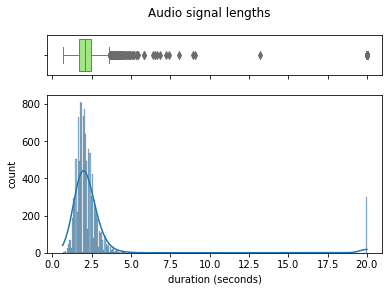

In [823]:
print("First Part: ")
#Apply the cut to both dev and eval data with the threshold value previously defined... 
#Normalized amplitude:
To_clean['Audio_features_Norm']=normalize_data(To_clean.Audio_features)

#Length and duration normalization. Audio signals have different length and duration.
To_clean["DurationsOrg"]=Get_Durations_audio_features(To_clean.Audio_features_Norm.tolist(),16000)
To_clean["LengthsOrg"]=Get_lengths_audio_features(To_clean.Audio_features_Norm.tolist())

To_clean['Audio_silence_Norm'] = [remove_silence(x) for x in To_clean.Audio_features_Norm]
display(To_clean.head(2))

#Audio signals have different duration.
show_length_distribution(To_clean.DurationsOrg.values)

#Now, looking at the distribution of the signal lengths you can see that they are very well distributed.
Get_lengths_audio_features(Train.Audio_features_Norm)
print("Plot lenght audio features before apply Cut function:")
plt.hist(Train.Lenghts)
plt.title("Audio samples length distribution")
plt.xlabel("Length")
plt.ylabel("# occurrences")
plt.show()
plt.close()
print("")
plt.hist(Get_lengths_audio_features(Cut_Features))
plt.title("Audio samples length distribution after applying Cut function:")
plt.xlabel("Length")
plt.ylabel("# occurrences")
plt.show()
plt.close()

In [327]:
print("Second Part: ")
perc = 95
length_95_perc = int(np.ceil(np.percentile(To_clean.LengthsOrg, perc)))
print(f"The {perc}% of the data has length lower or equal to {length_95_perc}.")

Cut_Audio = Cut_Audio_Features(To_clean.Audio_silence_Norm,length_95_perc)
Pad_Audio = Padding_sample_audio(Cut_Audio,length_95_perc)
To_clean['Audio_sil_Norm_Uniform'] = Pad_Audio
display(To_clean.head(2))

Second Part: 
The 95% of the data has length lower or equal to 55979.


,Audio_features,Target,Audio_features_Norm,DurationsOrg,LengthsOrg,Audio_silence_Norm,Audio_sil_Norm_Uniform
36,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",decreasevolume,"[0.0005575542, 0.0005575542, 0.0005575542, 0.0...",20.0,320000,"[-0.0031848878134042025, 0.0005960284033790231...","[-0.0031848878134042025, 0.0005960284033790231..."
55,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",deactivatelights,"[0.00044240238, 0.00044240238, 0.00044240238, ...",20.0,320000,"[-0.06441788375377655, -0.010862460359930992, ...","[-0.06441788375377655, -0.010862460359930992, ..."


In [209]:
#https://towardsdatascience.com/understanding-audio-data-fourier-transform-fft-spectrogram-and-speech-recognition-a4072d228520
#https://ngbala6.medium.com/audio-processing-and-remove-silence-using-python-a7fe1552007a

In [328]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

def preprocessing_std_and_MinMaxScaler(X):
    X_to_scale = X.copy()
    names = ["X_%s" % x for x in range(X_to_scale.shape[1])]
    #Convert to table format - MinMaxScaler
    scaler = MinMaxScaler()
    scaled_features = scaler.fit_transform(X_to_scale)
    df_MinMax = pd.DataFrame(data=scaled_features,index=X_to_scale.index,columns=names)
    #Convert to table format - StandardScaler
    sc_X = StandardScaler()
    sc_X = sc_X.fit_transform(X_to_scale) 
    sc_X = pd.DataFrame(data=sc_X,index=X_to_scale.index, columns=names)
    return sc_X,df_MinMax

In [738]:
def Train_Classification_Model(Xtrain,Ytrain,ts):
    
    # Train Test split:
    X_train, X_test, y_train, y_test = train_test_split(Xtrain,Ytrain,
                                                        test_size=ts,
                                                        stratify=Ytrain,
                                                        random_state=34)
    
    # Multi-Label Classification model:
    Classifications = [ExtraTreesClassifier(),RandomForestClassifier(),KNeighborsClassifier()]
    # Train Model:
    for model in Classifications:
        # train model 
        start = time()
        model.fit(X_train, y_train)
        train_time = time() - start
        print("\n\n>>>> Classifiers :",model)   
        print("\tTraining time: %0.3fs" % train_time)
        
        # Predict values for Test dataset
        start = time()
        y_pred = model.predict(X_test)
        predict_time = time()-start
        print("\tPrediction time: %0.3fs" % predict_time)

        # Print the evaluation metrics for the dataset.
        #print(classification_report(y_test, y_pred))
        Accuracy = round(accuracy_score(y_test, y_pred),3)
        
        # Print the evaluation f1_macro metrics for the dataset.
        print(f"accuracy_score(When the model see new data): ",Accuracy* 100, "% accuracy score")
        
        # Compute and plot the Confusion matrix
        cf_matrix = confusion_matrix(y_test, y_pred)
        plt.close()
        
        #
        #confusion_matrix_matplotlib(y_test, y_pred)
        print("\n\n>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> ")
def create_train_and_test_dataset(df_clean,Target):
    #which data tranformation do you want to train:
    Dataset = df_clean.copy()
    #add target to full dataset
    Dataset['Target'] = Target
    #Devide full dataset in train data and evaluation dataset:
    #define mask to extract Dev features
    mask1=Dataset['Target']!='unknown'
    #define mask for eval to extract Eval features:
    mask2=Dataset['Target']=='unknown'
    #Train and Test extraction features:
    X_dev, y_dev, X_ev = Dataset[mask1].drop('Target', axis=1),Dataset[mask1]['Target'],Dataset[mask2].drop('Target', axis=1)
    return  X_dev, y_dev, X_ev

# Feature Extraction
- Extraction of features is a very important part in analyzing and finding relations between different things. As we already know that the data provided of audio cannot be understood by the models directly so we need to convert them into an understandable format for which feature extraction is used.


The audio signal is a three-dimensional signal in which three axes represent time, amplitude and frequency.

![image.png](https://miro.medium.com/max/633/1*7sKM9aECRmuoqTadCYVw9A.jpeg)

In [815]:
def spectrogram(samples, sample_rate, stride_ms = 10.0, 
                          window_ms = 20.0, max_freq = None, eps = 1e-14):

    stride_size = int(0.001 * sample_rate * stride_ms)
    window_size = int(0.001 * sample_rate * window_ms)

    # Extract strided windows
    truncate_size = (len(samples) - window_size) % stride_size
    samples = samples[:len(samples) - truncate_size]
    nshape = (window_size, (len(samples) - window_size) // stride_size + 1)
    nstrides = (samples.strides[0], samples.strides[0] * stride_size)
    windows = np.lib.stride_tricks.as_strided(samples, 
                                          shape = nshape, strides = nstrides)
    
    assert np.all(windows[:, 1] == samples[stride_size:(stride_size + window_size)])

    # Window weighting, squared Fast Fourier Transform (fft), scaling
    weighting = np.hanning(window_size)[:, None]
    
    fft = np.fft.rfft(windows * weighting, axis=0)
    fft = np.absolute(fft)
    fft = fft**2
    
    scale = np.sum(weighting**2) * sample_rate
    fft[1:-1, :] *= (2.0 / scale)
    fft[(0, -1), :] /= scale
    
    # Prepare fft frequency list
    freqs = float(sample_rate) / window_size * np.arange(fft.shape[0])
    
    # Compute spectrogram feature
    ind = np.where(freqs <= max_freq)[0][-1] + 1
    specgram = np.log(fft[:ind, :] + eps)
    return specgram

def Feature_extraction(ds,freq):
    Features=[]
    for audio in ds.Audio_sil_Norm_Uniform.values:
        sperc = spectrogram(audio, 16000, stride_ms = 10.0, window_ms = 20.0, max_freq = freq, eps = 1e-14)
        #Get the mean of array in column-wise 
        mean = np.mean(sperc,dtype = np.float32, axis=0)
        Features.append(mean)
    return Features

# Find the max frequency

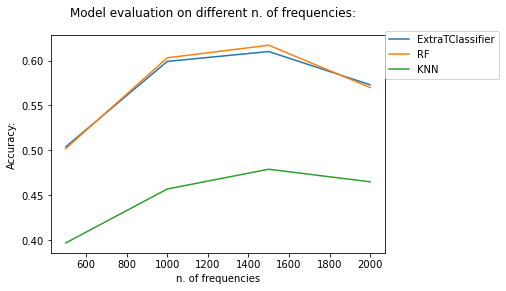

In [474]:
rs,num_column,ts=100,348,0.20 # 348
models = {
    "etc":ExtraTreesClassifier(random_state=rs),
    "rfc":RandomForestClassifier(random_state=rs),
    "knn":KNeighborsClassifier()
}
scores = {}
for n in range(500,2500,500): #for n in range(900,1000,50):
    Features=Feature_extraction(To_clean,n)
    df_spec = pd.DataFrame(data=Features,index=To_clean.index,columns=["X_%s" % x for x in range(num_column)])
    #Xsc, XMinsc = preprocessing_std_and_MinMaxScaler(df_spec)
    #which data tranformation do you want to train:
    X, y,_ = create_train_and_test_dataset(df_spec,To_clean['Target'].values)
    # Train Test split:
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=ts,stratify=y,random_state=34)
    score = []
    for model in models:
        clf = models[model]
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        Accuracy = round(accuracy_score(y_test, y_pred),3)
        #p,r,f,s = precision_recall_fscore_support(y_test, y_pred)
        score.append((model,Accuracy))
    scores[n] = score
    

etc_scores = [x[0][1] for x in scores.values()]
rfc_scores = [x[1][1] for x in scores.values()]
knn_scores = [x[2][1] for x in scores.values()]
x = scores.keys()

plt.plot(x, etc_scores, label = 'ExtraTClassifier')
plt.plot(x, rfc_scores, label = 'RF')
plt.plot(x, knn_scores, label= 'KNN')

plt.legend(loc = (1,.8))
plt.suptitle("Model evaluation on different n. of frequencies:")
plt.xlabel("n. of frequencies")
plt.ylabel('Accuracy:')
plt.show()

In [818]:
max_freq=1530
Features=Feature_extraction(To_clean,max_freq)
df_spec = pd.DataFrame(data=Features,index=To_clean.index,columns=["X_%s" % x for x in range(num_column)])
Xsc, XMinsc = preprocessing_std_and_MinMaxScaler(df_spec)

In [801]:
#which data tranformation do you want to train:
X, y ,X_eval = create_train_and_test_dataset(df_spec,To_clean['Target'].values)
#Train classification model:
Train_Classification_Model(X, y, ts)



>>>> Classifiers : ExtraTreesClassifier()
	Training time: 1.501s
	Prediction time: 0.048s
accuracy_score(When the model see new data):  60.699999999999996 % accuracy score


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> 


>>>> Classifiers : RandomForestClassifier()
	Training time: 3.468s
	Prediction time: 0.039s
accuracy_score(When the model see new data):  62.7 % accuracy score


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> 


>>>> Classifiers : KNeighborsClassifier()
	Training time: 0.011s
	Prediction time: 0.567s
accuracy_score(When the model see new data):  47.9 % accuracy score


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> 


# Part 2: Handle Categorical Features

In [722]:
print("*************** PART 1 ***************")
categorical_cols = ['Self-reported fluency level ','First Language spoken',
                    'Current language used for work/school','gender', 'ageRange']

Tp = full_data[categorical_cols].copy()
list_columns = list(Tp.columns)
percentage = []
Number_unique = []
print("*** Count unique values in a single column ***")
for feature in list_columns:
    #  Count unique values in every column of the dataframe
    uniqueValues = Tp[feature].nunique()
    percentage.append(np.round(uniqueValues/Tp.shape[0],4))
    Number_unique.append(uniqueValues)

# Create DataFrame 
Df_Uniquevalue = pd.DataFrame(data = {'Number_of_unique': Number_unique,'Percentage(%)': percentage},index=list_columns) 
display(Df_Uniquevalue)




# Count the N categories in a variable for each Categorical columns:
Categ_cols=['speakerId', 'action', 'object', 'Self-reported fluency level ',
       'First Language spoken', 'Current language used for work/school',
       'gender', 'ageRange','Target']

CategoricalCount=[]
for column in Categ_cols:
    unique, counts = np.unique(Tp[column].values, return_counts = True)
    CategoricalCount.append(len(unique))

ds ={'Categorical columns':Categ_cols, 'Distinct_variable':CategoricalCount}
df_Categ = pd.DataFrame(ds)
df_Categ


print("*************** PART 2 ***************")
# creating initial dataframe
subcategorical_cols = ['Self-reported fluency level ','First Language spoken',
                       'Current language used for work/school',
                       'gender', 'ageRange','Target']

Tmp = full_data[mask1][subcategorical_cols].copy()
print("Before apply Mean Ordinal Encoding")
display(Tmp.head(2))

# creating instance of labelencoder
labelencoder = LabelEncoder()
# Assigning numerical values and storing in another column
Tmp['Target'] = labelencoder.fit_transform(Tmp['Target'])
sub = ['Self-reported fluency level ','gender', 'ageRange',
       'First Language spoken','Current language used for work/school']

#Mean Ordinal Encoding
mean_ordinals = []
for col in sub:
    #print("For column:",col)
    mean_ordinal = Tmp.groupby([col])['Target'].mean().to_dict()
    #print(mean_ordinal)
    print("")
    mean_ordinals.append(mean_ordinal)
print("Mean Ordinal Encoding")
df_Mean_Ordinal = full_data[subcategorical_cols].copy()
for col,Encoding in zip(sub,mean_ordinals):
    #We replace the category with the obtained mean value instead of assigning integer values to it.
    df_Mean_Ordinal[col]=df_Mean_Ordinal[col].map(Encoding)

display(df_Mean_Ordinal.head(2))

print("*************** PART 3 ***************")
#which data tranformation do you want to train:
# now concatenate the original data and the encoded data using pandas
Dataset = pd.concat([df_spec,df_Mean_Ordinal], axis=1)

#Devide full dataset in train data and evaluation dataset:
#define mask for dev
mask1=Dataset['Target']!='unknown'
#define mask for eval
mask2=Dataset['Target']=='unknown'

#Train extraction features:
X, y, ts = Dataset[mask1].drop('Target', axis=1),Dataset[mask1]['Target'],0.2

#Eval extraction features:
mask2=Dataset['Target']=='unknown'
X_eval = Dataset[mask2].drop('Target', axis=1)

#Train classification model:
Train_Classification_Model(X, y, ts)

*************** PART 1 ***************
*** Count unique values in a single column ***


,Number_of_unique,Percentage(%)
Self-reported fluency level,4,0.0004
First Language spoken,5,0.0004
Current language used for work/school,4,0.0004
gender,2,0.0002
ageRange,3,0.0003


*************** PART 2 ***************
Before apply Mean Ordinal Encoding


,Self-reported fluency level,First Language spoken,Current language used for work/school,gender,ageRange,Target
36,advanced,English (United States),English (United States),female,22-40,decreasevolume
55,advanced,English (United States),English (United States),female,22-40,deactivatelights







Mean Ordinal Encoding


,Self-reported fluency level,First Language spoken,Current language used for work/school,gender,ageRange,Target
36,3.710983,3.763431,3.7612,3.763129,3.768543,decreasevolume
55,3.710983,3.763431,3.7612,3.763129,3.768543,deactivatelights


*************** PART 3 ***************


>>>> Classifiers : ExtraTreesClassifier()
	Training time: 1.891s
	Prediction time: 0.061s
accuracy_score(When the model see new data):  62.0 % accuracy score


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> 


>>>> Classifiers : RandomForestClassifier()
	Training time: 3.475s
	Prediction time: 0.052s
accuracy_score(When the model see new data):  61.9 % accuracy score


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> 


>>>> Classifiers : KNeighborsClassifier()
	Training time: 0.012s
	Prediction time: 0.467s
accuracy_score(When the model see new data):  47.9 % accuracy score


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> 


Class=decreasevolume, n=2386 (20.023%)
Class=deactivatelights, n=2614 (21.937%)
Class=activatemusic, n=791 (6.638%)
Class=increaseheat, n=1209 (10.146%)
Class=increasevolume, n=2614 (21.937%)
Class=decreaseheat, n=1189 (9.978%)
Class=change languagenone, n=1113 (9.340%)


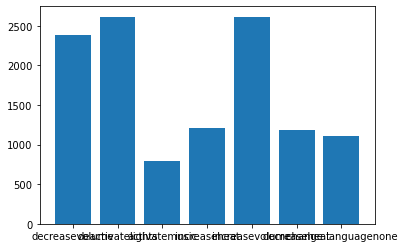

In [731]:
from collections import Counter
from matplotlib import pyplot
#Create an oversampled training data
oversample = SMOTE(sampling_strategy='minority')
X_over, y_over = oversample.fit_resample(X, y)
# summarize distribution
counter = Counter(y_over)
for k,v in counter.items():
    per = v / len(y_over) * 100
    print('Class=%s, n=%d (%.3f%%)' % (k, v, per))
# plot the distribution
pyplot.bar(counter.keys(), counter.values())
pyplot.show()

# Hyperperameter tuning

In [749]:
from sklearn.pipeline import Pipeline, make_pipeline
from imblearn.pipeline import make_pipeline
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, RandomizedSearchCV



skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
sss = StratifiedShuffleSplit(n_splits=5, test_size=0.20,random_state=0)

In [824]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    stratify=y,
                                                    random_state=11)
print('Length of X (train): {} | Length of y (train): {}'.format(len(X_train), len(y_train)))
print('Length of X (test): {} | Length of y (test): {}'.format(len(y_test), len(y_test)))

# Random forest
# n_jobs=-1 to allow run it on all cores
params = {
    'n_estimators': [200,350,600,800],
    'criterion': ['gini', 'entropy'],
    'min_samples_split': [1,2,4,5],
    'min_samples_leaf': [1,2,4,5],
    'max_leaf_nodes': [4,10,20,30,50,None]
}

gs = GridSearchCV(RandomForestClassifier(n_jobs=-1), params, n_jobs=-1, cv=skf, scoring='accuracy')
gs.fit(X_train, y_train)

# examine the best model

# best score achieved during the GridSearchCV
print('GridSearch CV best score : {:.4f}\n\n'.format(gs.best_score_))

print('GridSearch CV test score : {:.4f}\n\n'.format(gs.score(X_test, y_test)))

# print parameters that give the best results
print('Parameters that give the best results :','\n\n', (gs.best_params_))

# print estimator that was chosen by the GridSearch
print('\n\nEstimator that was chosen by the search :','\n\n', (gs.best_estimator_))


# Predict values for Test dataset
start = time()
y_pred = gs.best_estimator_.predict(X_test) #original_Xtest, original_ytrain, original_ytest
predict_time = time()-start
print("\tPrediction time: %0.3fs" % predict_time)
# Print the evaluation metrics for the dataset.
print(classification_report(y_test, y_pred))
Accuracy = round(accuracy_score(y_test, y_pred),3)
# Print the evaluation f1_macro metrics for the dataset.
print(f"accuracy_score(When the model see new data): ",Accuracy* 100, "% accuracy score")

Length of X (train): 7883 | Length of y (train): 7883
Length of X (test): 1971 | Length of y (test): 1971
GridSearch CV best score : 0.6135


GridSearch CV test score : 0.6098


Parameters that give the best results : 

 {'criterion': 'entropy', 'max_leaf_nodes': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 800}


Estimator that was chosen by the search : 

 RandomForestClassifier(criterion='entropy', n_estimators=800, n_jobs=-1)
	Prediction time: 0.153s
                     precision    recall  f1-score   support

      activatemusic       0.63      0.65      0.64       158
change languagenone       0.70      0.62      0.66       223
   deactivatelights       0.89      0.36      0.52       110
       decreaseheat       0.60      0.43      0.50       238
     decreasevolume       0.61      0.65      0.63       477
       increaseheat       0.63      0.46      0.53       242
     increasevolume       0.56      0.76      0.65       523

           accuracy        

# Hyperparameter Optimization using GridSearch CV 

Model evaluation & optimization
As our dataset is not too big, we will use GridSearchCV for parameter tuning, in case of large datasets RandomizedSearchCV could be better. Our main objective will be to improve accuracy score and avoid overfitting

### SMOTE Technique (Over-Sampling):
<b>SMOTE</b> stands for Synthetic Minority Over-sampling Technique.  Unlike Random UnderSampling, SMOTE creates new synthetic points in order to have an equal balance of the classes. This is another alternative for solving the "class imbalance problems". <br><br>

<b> Understanding SMOTE: </b>
<ul>
<li> <b> Solving the Class Imbalance: </b> SMOTE creates synthetic points from the minority class in order to reach an equal balance between the minority and majority class. </li>
<li><b>Location of the synthetic points: </b>   SMOTE picks the distance between the closest neighbors of the minority class, in between these distances it creates synthetic points. </li>
<li> <b>Final Effect:  </b> More information is retained since we didn't have to delete any rows unlike in random undersampling.</li>
<li><b> Accuracy || Time Tradeoff: </b> Although it is likely that SMOTE will be more accurate than random under-sampling, it will take more time to train since no rows are eliminated as previously stated.</li>

</ul>
## Overfitting during Cross Validation:  

### The Right Way:
<img src="https://www.marcoaltini.com/uploads/1/3/2/3/13234002/9101820.jpg?372"> <br>
As you see above, SMOTE occurs "during" cross validation and not "prior" to the cross validation process. Synthetic data are created only for the training set without affecting the validation set.


**References**: 
<ul>
<li><a src="https://www.marcoaltini.com/blog/dealing-with-imbalanced-data-undersampling-oversampling-and-proper-cross-validation"> 
DEALING WITH IMBALANCED DATA: UNDERSAMPLING, OVERSAMPLING AND PROPER CROSS-VALIDATION </a></li> 

<li> <a src="http://rikunert.com/SMOTE_explained "> SMOTE explained for noobs  </a></li>
<li> <a src="https://www.youtube.com/watch?v=DQC_YE3I5ig&t=794s"> Machine Learning - Over-& Undersampling - Python/ Scikit/ Scikit-Imblearn </a></li>
    
<li> <a src="https://towardsdatascience.com/the-right-way-of-using-smote-with-cross-validation-92a8d09d00c7"> The right way of using SMOTE with Cross-validation - Over-& Undersampling - Python/ Scikit/ Scikit-Imblearn </a></li>
    
    
    
</ul>

Method 1 : SMOTE with Cross-validation

In [443]:
original_Xtrain, original_Xtest, original_ytrain, original_ytest = train_test_split(X.values,y.values,
                                                                   test_size = 0.20,
                                                                   stratify=y,
                                                                   random_state = 123)
print('Length of X (train): {} | Length of y (train): {}'.format(len(original_Xtrain), len(original_ytrain)))
print('Length of X (test): {} | Length of y (test): {}'.format(len(original_Xtest), len(original_ytest)))

# List to append the score and then find the average
accuracy_lst = []

# Classifier with optimal parameters
# Implementing SMOTE Technique 
# Cross Validating the right way
# Parameters


#rf_parameters = {'n_estimators': [100,200,300,350], 
#              #'max_features': ['log2', 'sqrt','auto'],
#              "min_impurity_decrease": [0.0,0.05,0.1],
#              'criterion': ['gini','entropy'],
#              'max_depth': [10, 20, 30, 50], 
#              'min_samples_split': [2, 3, 5], # 10, 20, 30
#              'min_samples_leaf': [1,5,10]#,20,30,50
#             }

# Extra Tree
# n_jobs=-1 to allow run it on all cores
#params = {
#    'n_estimators': [100, 200, 500],
#    'criterion': ['gini', 'entropy'],
#    'min_samples_split': [1,2,4,5],
#    'min_samples_leaf': [1,2,4,5],
#    'max_leaf_nodes': [4,10,20,50,None]
#}

rf_parameters = {'n_estimators': [150,250, 350, 450], 
                 'criterion': ["gini", "entropy"],
                 'max_depth': [30,50,None]
                }
# n_jobs=-1 to allow run it on all cores
rand_rf = RandomizedSearchCV(RandomForestClassifier(n_jobs=-1), rf_parameters, n_iter=4)


#rand_rf = GridSearchCV(RandomForestClassifier(n_jobs=-1), rf_parameters, n_jobs=-1, cv=skf, scoring='accuracy')

Accuracy_best = 0
count=0
for train, test in sss.split(original_Xtrain, original_ytrain):
    print("Folder :",count)
    pipeline = make_pipeline(SMOTE(sampling_strategy='minority'),
                             rand_rf
                            ) # SMOTE happens during Cross Validation not before..
    model = pipeline.fit(original_Xtrain[train], original_ytrain[train])
    best_est = rand_rf.best_estimator_
    prediction = best_est.predict(original_Xtrain[test])
    Accuracy = round(accuracy_score(original_ytrain[test], prediction),5)
    if Accuracy > Accuracy_best:
        Accuracy_best=Accuracy
        best_est_overall=rand_rf.best_estimator_
    # Print the evaluation f1_macro metrics for the dataset.
    print(f"accuracy_score(When the model see new data): ",Accuracy* 100, "% accuracy score")
    print("best Parameters for RandomForestClassifier model: ", rand_rf.best_params_)
    accuracy_lst.append(pipeline.score(original_Xtrain[test], original_ytrain[test]))
    count=count+1
    print(">>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>")
print('---' * 4)
print('')
print("accuracy: {}".format(np.mean(accuracy_lst)))
print("best Parameters for RandomForestClassifier model:\n", best_est_overall)
print('---' * 4)

Length of X (train): 7883 | Length of y (train): 7883
Length of X (test): 1971 | Length of y (test): 1971
Folder : 0
accuracy_score(When the model see new data):  64.976 % accuracy score
best Parameters for RandomForestClassifier model:
 {'n_estimators': 450, 'max_depth': 30, 'criterion': 'entropy'}
best score: 0.6784903474030355
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
Folder : 1
accuracy_score(When the model see new data):  61.885999999999996 % accuracy score
best Parameters for RandomForestClassifier model:
 {'n_estimators': 450, 'max_depth': 50, 'criterion': 'entropy'}
best score: 0.6841137834421527
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
Folder : 2
accuracy_score(When the model see new data):  62.361 % accuracy score
best Parameters for RandomForestClassifier model:
 {'n_estimators': 350, 'max_depth': None, 'criterion': 'entropy'}
best score: 0.6783660493090695
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
Folder : 3
accuracy_score(When the model see new data):  62.995000000000005 % accurac

In [445]:
# Multi-Label Classification model:
model = RandomForestClassifier(criterion='entropy', max_depth=30, n_estimators=450,n_jobs=-1)
# Train Model:
start = time()
model.fit(original_Xtrain, original_ytrain)  #original_Xtrain, original_Xtest, original_ytrain, original_ytest
train_time = time() - start  
print("\tTraining time: %0.3fs" % train_time)

# Predict values for Test dataset
start = time()
y_pred = model.predict(original_Xtest) #original_Xtest, original_ytrain, original_ytest
predict_time = time()-start
print("\tPrediction time: %0.3fs" % predict_time)

# Print the evaluation metrics for the dataset.
print(classification_report(original_ytest, y_pred))
Accuracy = round(accuracy_score(original_ytest, y_pred),3)
# Print the evaluation f1_macro metrics for the dataset.
print(f"accuracy_score(When the model see new data): ",Accuracy* 100, "% accuracy score")

	Training time: 6.447s
	Prediction time: 0.081s
                     precision    recall  f1-score   support

      activatemusic       0.57      0.63      0.60       158
change languagenone       0.76      0.67      0.71       223
   deactivatelights       0.84      0.38      0.53       110
       decreaseheat       0.59      0.45      0.51       238
     decreasevolume       0.63      0.69      0.66       477
       increaseheat       0.62      0.47      0.53       242
     increasevolume       0.60      0.76      0.68       523

           accuracy                           0.63      1971
          macro avg       0.66      0.58      0.60      1971
       weighted avg       0.64      0.63      0.63      1971

accuracy_score(When the model see new data):  63.1 % accuracy score


Method 2: SMOTE while using cross-validation.

In [797]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    stratify=y,
                                                    random_state=11)


pipeline = imbpipeline(steps = [['smote', SMOTE(random_state=11)],
                                ['scaler', MinMaxScaler()],
                                ['classifier', RandomForestClassifier(n_jobs=-1)]])

#stratified_kfold = StratifiedKFold(n_splits=5,shuffle=True,random_state=11)
    
param_grid = {'classifier__n_estimators': [200,350,400,500,600], 
              'classifier__min_impurity_decrease': [0.0,0.05,0.07,0.1],
              'classifier__criterion': ['gini','entropy'],
              'classifier__max_depth': [10,30,50,None]
             }


grid_search = GridSearchCV(estimator=pipeline,
                           param_grid=param_grid,
                           scoring='accuracy',
                           cv=skf,
                           n_jobs=-1)

grid_search.fit(X_train, y_train)

# examine the best model

# best score achieved during the GridSearchCV
print('GridSearch CV best score : {:.4f}\n\n'.format(grid_search.best_score_))

print('GridSearch CV test score : {:.4f}\n\n'.format(grid_search.score(X_test, y_test)))

#print(f'Cross-validation score: {cv_score}\nTest score: {test_score}')

# print parameters that give the best results
print('Parameters that give the best results :','\n\n', (grid_search.best_params_))

# print estimator that was chosen by the GridSearch
print('\n\nEstimator that was chosen by the search :','\n\n', (grid_search.best_estimator_))


# Predict values for Test dataset
start = time()
y_pred = grid_search.best_estimator_.predict(X_test) #original_Xtest, original_ytrain, original_ytest
predict_time = time()-start
print("\tPrediction time: %0.3fs" % predict_time)
# Print the evaluation metrics for the dataset.
print(classification_report(y_test, y_pred))
Accuracy = round(accuracy_score(y_test, y_pred),3)
# Print the evaluation f1_macro metrics for the dataset.
print(f"accuracy_score(When the model see new data): ",Accuracy* 100, "% accuracy score")

GridSearch CV best score : 0.6286


GridSearch CV test score : 0.6438


Parameters that give the best results : 

 {'classifier__criterion': 'entropy', 'classifier__max_depth': 30, 'classifier__min_impurity_decrease': 0.0, 'classifier__n_estimators': 600}


Estimator that was chosen by the search : 

 Pipeline(steps=[('smote', SMOTE(random_state=11)), ('scaler', MinMaxScaler()),
                ['classifier',
                 RandomForestClassifier(criterion='entropy', max_depth=30,
                                        n_estimators=600, n_jobs=-1)]])
	Prediction time: 0.112s
                     precision    recall  f1-score   support

      activatemusic       0.57      0.75      0.65       158
change languagenone       0.63      0.74      0.68       223
   deactivatelights       0.63      0.66      0.65       110
       decreaseheat       0.61      0.57      0.59       238
     decreasevolume       0.67      0.60      0.63       477
       increaseheat       0.62      0.55      0.

In [799]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    stratify=y,
                                                    random_state=11)


pipeline = imbpipeline(steps = [['smote', SMOTE(random_state=178)],
                                ['scaler', StandardScaler()],
                                ['classifier', RandomForestClassifier(n_jobs=-1)]])

#stratified_kfold = StratifiedKFold(n_splits=5,shuffle=True,random_state=11)
    
param_grid = {'classifier__n_estimators': [100,200,350,400], 
              'classifier__min_impurity_decrease': [0.0,0.05,0.07,0.1],
              'classifier__criterion': ['gini','entropy']
             }


grid_search = GridSearchCV(estimator=pipeline,
                           param_grid=param_grid,
                           scoring='accuracy',
                           cv=sss,
                           n_jobs=-1)

grid_search.fit(X_train, y_train)

# examine the best model

# best score achieved during the GridSearchCV
print('GridSearch CV best score : {:.4f}\n\n'.format(grid_search.best_score_))

print('GridSearch CV test score : {:.4f}\n\n'.format(grid_search.score(X_test, y_test)))

#print(f'Cross-validation score: {cv_score}\nTest score: {test_score}')

# print parameters that give the best results
print('Parameters that give the best results :','\n\n', (grid_search.best_params_))

# print estimator that was chosen by the GridSearch
print('\n\nEstimator that was chosen by the search :','\n\n', (grid_search.best_estimator_))


# Predict values for Test dataset
start = time()
y_pred = grid_search.best_estimator_.predict(X_test) #original_Xtest, original_ytrain, original_ytest
predict_time = time()-start
print("\tPrediction time: %0.3fs" % predict_time)
# Print the evaluation metrics for the dataset.
print(classification_report(y_test, y_pred))
Accuracy = round(accuracy_score(y_test, y_pred),3)
# Print the evaluation f1_macro metrics for the dataset.
print(f"accuracy_score(When the model see new data): ",Accuracy* 100, "% accuracy score")

GridSearch CV best score : 0.6257


GridSearch CV test score : 0.6332


Parameters that give the best results : 

 {'classifier__criterion': 'entropy', 'classifier__min_impurity_decrease': 0.0, 'classifier__n_estimators': 400}


Estimator that was chosen by the search : 

 Pipeline(steps=[('smote', SMOTE(random_state=178)),
                ('scaler', StandardScaler()),
                ['classifier',
                 RandomForestClassifier(criterion='entropy', n_estimators=400,
                                        n_jobs=-1)]])
	Prediction time: 0.093s
                     precision    recall  f1-score   support

      activatemusic       0.56      0.74      0.64       158
change languagenone       0.65      0.74      0.69       223
   deactivatelights       0.64      0.67      0.66       110
       decreaseheat       0.56      0.55      0.55       238
     decreasevolume       0.66      0.59      0.62       477
       increaseheat       0.58      0.52      0.55       242
     increa

# Predict Values of field the target in Eval dataset

In [788]:
#Choose the best model to predict target column:
model = RandomForestClassifier(criterion='gini', max_depth=30, n_estimators=350,n_jobs=-1)
#model = RandomForestClassifier(n_estimators=250,criterion='entropy',max_depth=50,n_jobs=-1)
# Train Model:
start = time()
# train model
model.fit(X, y)
train_time = time() - start
start = time()   
print("\tTraining time: %0.3fs" % train_time)

#predict the label encoder of eval dataset
y_pred = model.predict(X_eval)
pd.DataFrame(y_pred, index=To_clean[To_clean['Target']=='unknown'].index).to_csv('Output.csv', index_label="Id", header=["Predicted"])
print(f'The file has been save !!!!!.')
Output = pd.read_csv('Output.csv')
print('Dimenssione del submit_file model :', Output.shape)
print(Output.head(10))

	Training time: 3.368s
The file has been save !!!!!.
Dimenssione del submit_file model : (1455, 2)
   Id         Predicted
0   0    decreasevolume
1   1      increaseheat
2   2      increaseheat
3   3     activatemusic
4   4    decreasevolume
5   5    increasevolume
6   6    decreasevolume
7   7  deactivatelights
8   8      decreaseheat
9   9  deactivatelights
